In [1]:
import keras
import numpy as np
import pandas as pd
import os
import cv2
import PIL.Image as Image
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers.normalization import BatchNormalization

from numpy.random import seed
import tensorflow as tf
import keras.backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D

In [ ]:
m = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/classification/4"
pretrained_model = hub.KerasLayer(
    m, input_shape=(128,128,3), trainable=False)

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ff1b66da364a8635d4377d8d34a85c2fc24a37e9db1b19deb8c0f625b75d1b12
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faseehlodhi","key":"7e405e74b1eef49882a04ec0362e4251"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Downloading the dataset from kaggle
!kaggle competitions download -c uos-com2028

 98% 813M/827M [00:08<00:00, 72.2MB/s]
100% 827M/827M [00:08<00:00, 98.4MB/s]


In [ ]:
# Unzip the dataset
!unzip uos-com2028.zip -d uos-com2028

In [7]:
# Importing the training images into x_train as numpy array, resizing it (140,140); 
from skimage.io import imread
from tqdm import tqdm
train_list = '/content/uos-com2028/train/train'
image_array = [None] * 10270
for image in tqdm(os.listdir(train_list)):
  path = os.path.join(train_list, image)
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (140,140))
  image = image[:-4]
  image_array[int(image)] = np.array(img)
 
x_train = np.array(image_array)

100%|██████████| 10270/10270 [00:38<00:00, 265.91it/s]


In [35]:
# Importing the training images into x_test as numpy array, resizing it (140,140); 
from skimage.io import imread
from tqdm import tqdm
test_list = '/content/uos-com2028/test/test'
image_array2 = [None] * 15009
for image in tqdm(os.listdir(test_list)):
  path = os.path.join(test_list, image)
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (140,140))
  image = image[:-4]
  image_array2[int(image)] = np.array(img)

x_test = np.array(image_array2)

100%|██████████| 15009/15009 [01:04<00:00, 234.46it/s]


In [33]:
# Normalization of the data(x_train)
x_train = x_train/255

In [36]:
# Normalization of the data(x_test)
x_test = x_test/255

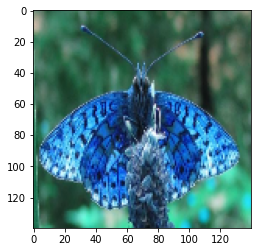

In [9]:
plt.imshow(x_train[60])

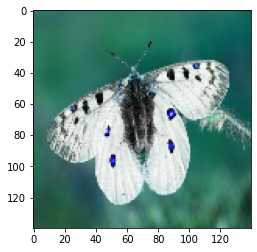

In [ ]:
plt.imshow(x_test[380])

In [10]:
# Imorting the categories into y_train from train.txt
target = []
with open('/content/uos-com2028/train.txt') as infile:
   lines = infile.readlines()
   for line in lines:
       for n in line.split()[1:]:
           target.append(int(n))

y_train = np.array(target)     

In [11]:
# Using to_categorical function
y_train = to_categorical(y_train)

In [12]:
y_train.shape

(10270, 23)

In [13]:
# Creating validation set using 10 percent of our original x_train,y_train dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 0)

In [34]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9243, 140, 140, 3)
(9243, 23)
(1027, 140, 140, 3)
(1027, 23)


In [15]:
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.layers import Dropout, Activation, MaxPool2D
from keras.optimizers import RMSprop
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.python.keras import regularizers

In [ ]:
# This is the first model I used but it wasnt that efficient I will just use it compare it with my second model in graphs etc
# this model gives me 56 percent accuracy on the test so it perform really poor
# the accuracy of this model reaches 98 percent but the validation accuracy is stuck at 56 percent so its overfitting
model1 = Sequential()

model1.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(140,140,3)))
model1.add(Conv2D(64, kernel_size=3, activation="relu"))
model1.add(MaxPooling2D(pool_size=(3,3)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, kernel_size=3, activation="relu"))
model1.add(MaxPooling2D(pool_size=(3,3)))
model1.add(Dropout(0.3))


model1.add(Flatten())
# Dense layer with our output categories
model1.add(Dense(23, activation="softmax"))
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=50, batch_size=64)

Epoch 1/50
145/145 [==============================] - 10s 62ms/step - loss: 2.6085 - accuracy: 0.2345 - val_loss: 2.0654 - val_accuracy: 0.4090
Epoch 2/50
145/145 [==============================] - 8s 59ms/step - loss: 1.8802 - accuracy: 0.4342 - val_loss: 1.7910 - val_accuracy: 0.4703
Epoch 3/50
145/145 [==============================] - 9s 59ms/step - loss: 1.5831 - accuracy: 0.5170 - val_loss: 1.7231 - val_accuracy: 0.4898
Epoch 4/50
145/145 [==============================] - 8s 59ms/step - loss: 1.3022 - accuracy: 0.5993 - val_loss: 1.6399 - val_accuracy: 0.5073
Epoch 5/50
145/145 [==============================] - 9s 59ms/step - loss: 1.0607 - accuracy: 0.6754 - val_loss: 1.5732 - val_accuracy: 0.5404
Epoch 6/50
145/145 [==============================] - 8s 59ms/step - loss: 0.8045 - accuracy: 0.7514 - val_loss: 1.6543 - val_accuracy: 0.5209
Epoch 7/50
145/145 [==============================] - 9s 59ms/step - loss: 0.6335 - accuracy: 0.7965 - val_loss: 1.7691 - val_accuracy: 0.524

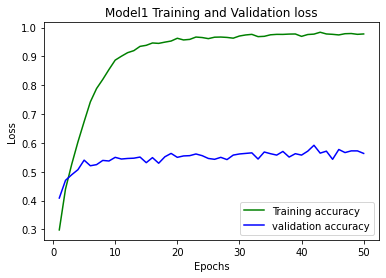

In [ ]:
loss_train = history1.history['accuracy']
loss_val = history1.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Model1 Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Creating my second model that is much efficient than the first one
# this model performs 80% on the test set which makes it 25% better than my previous model
model = Sequential()
# CNN used and a Maxpooling2D and a dropout
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(140,140,3)))
model.add(Conv2D(64, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))

#Using a maxpooling of 5 by 5
# Changing the Conv2D to 256 filters
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Dropout(0.3))

# adding the last layer with 128 filters and a Maxpooling of 3 by 3
model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.5))

model.add(Flatten())
# Dense layer with our output categories
model.add(Dense(23, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 138, 138, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 136, 136, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 43, 43, 256)       147712    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)        

In [22]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# String the model in history and using a batch size of 128 with 100 epoch
history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100, batch_size=128)

Epoch 1/100
73/73 [==============================] - 13s 165ms/step - loss: 2.7960 - accuracy: 0.1739 - val_loss: 2.4872 - val_accuracy: 0.2512
Epoch 2/100
73/73 [==============================] - 12s 162ms/step - loss: 2.4510 - accuracy: 0.2817 - val_loss: 2.2114 - val_accuracy: 0.3437
Epoch 3/100
73/73 [==============================] - 12s 162ms/step - loss: 2.1996 - accuracy: 0.3569 - val_loss: 2.0395 - val_accuracy: 0.3836
Epoch 4/100
73/73 [==============================] - 12s 162ms/step - loss: 2.0370 - accuracy: 0.4075 - val_loss: 1.8952 - val_accuracy: 0.4460
Epoch 5/100
73/73 [==============================] - 12s 161ms/step - loss: 1.9011 - accuracy: 0.4283 - val_loss: 1.8502 - val_accuracy: 0.4557
Epoch 6/100
73/73 [==============================] - 12s 162ms/step - loss: 1.8297 - accuracy: 0.4546 - val_loss: 1.6714 - val_accuracy: 0.4791
Epoch 7/100
73/73 [==============================] - 12s 162ms/step - loss: 1.6887 - accuracy: 0.4911 - val_loss: 1.6368 - val_accuracy:

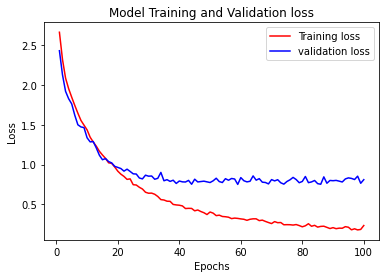

In [30]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Model Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

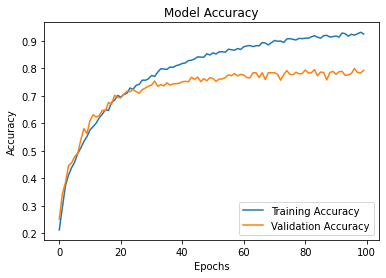

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'], loc='lower right')
plt.show()

In [ ]:
model.save('my_model.h5') 

In [ ]:
from keras.models import load_model
model2 = load_model('my_model.h5')

In [37]:
# predicting from our model on the test set
y_pred = model.predict(x_test) # make prediction here
y_pred = np.argmax(y_pred, axis=1)
print(len(y_pred))
print(y_pred[380])

15009
5


In [ ]:
# Creating a csv file with out y_pred
df = pd.read_csv("/content/uos-com2028/submission_sample.csv")
df["label"] = y_pred
df.to_csv("/content/final.csv", index=False)

In [ ]:
# Submitting the csv file to kaggle
!kaggle competitions submit -c uos-com2028 -f final.csv -m "submission"

100% 115k/115k [00:05<00:00, 23.6kB/s]
Successfully submitted to UoS COM2028 Coursework